# League of Legends Win Prediction with XGBoost

This notebook uses the Kaggle dataset [League of Legends Ranked Matches](https://www.kaggle.com/paololol/league-of-legends-ranked-matches) which contains 180,000 ranked games of League of Legends starting from 2014. Using this data we build an XGBoost model to predict if a player's team will win based on statistics about how that player played the match.

The methods used here are applicable to any dataset. We use this dataset to illustrate how SHAP values help make gradient boosted trees such as XGBoost interpretable. Due to the size, interaction effections, containing both catgoriacl and continuous features and its interpretability (particularly for players of the game) the dataset suits as a good example on various fronts. For more information on SHAP values see: https://github.com/shap/shap 

In [2]:
from pathlib import Path

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

import shap

shap.initjs()

## Load the dataset

To run this yourself you will need to download the dataset from Kaggle and ensure the `prefix` variable below is correct. To do so follow the link given above and download and extract the data. Change the `prefix` variable if needed.

In [14]:
# read in the data
folder_path = Path("C:\\Users\\azabe\\Downloads\\archive")
matches = pd.read_csv(folder_path / "matches.csv")
participants = pd.read_csv(folder_path / "participants.csv")
stats1 = pd.read_csv(folder_path / "stats1.csv", low_memory=False)
stats2 = pd.read_csv(folder_path / "stats2.csv", low_memory=False)
stats = pd.concat([stats1, stats2])

# merge into a single DataFrame
a = pd.merge(participants, matches, left_on="matchid", right_on="id", suffixes=("", "_matches"))
allstats_orig = pd.merge(a, stats, left_on="matchid", right_on="id", suffixes=("", "_stats"))
allstats = allstats_orig.copy()

# drop games that lasted less than 10 minutes
allstats = allstats.loc[allstats["duration"] >= 10 * 60, :]

# Convert string-based categories to numeric values
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype("category")
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

X = allstats.drop(columns=["win"])
y = allstats["win"]

# convert all features we want to consider as rates
rate_features = [
    "kills",
    "deaths",
    "assists",
    "killingsprees",
    "doublekills",
    "triplekills",
    "quadrakills",
    "pentakills",
    "legendarykills",
    "totdmgdealt",
    "magicdmgdealt",
    "physicaldmgdealt",
    "truedmgdealt",
    "totdmgtochamp",
    "magicdmgtochamp",
    "physdmgtochamp",
    "truedmgtochamp",
    "totheal",
    "totunitshealed",
    "dmgtoobj",
    "timecc",
    "totdmgtaken",
    "magicdmgtaken",
    "physdmgtaken",
    "truedmgtaken",
    "goldearned",
    "goldspent",
    "totminionskilled",
    "neutralminionskilled",
    "ownjunglekills",
    "enemyjunglekills",
    "totcctimedealt",
    "pinksbought",
    "wardsbought",
    "wardsplaced",
    "wardskilled",
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60  # per minute rate

# convert to fraction of game
X["longesttimespentliving"] /= X["duration"]

# define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets",
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

# create train/validation split
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

## Train the XGBoost model

In [16]:
params = {
    "objective": "binary:logistic",
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
}
model = xgb.train(
    params,
    dt,
    num_boost_round=10,
    evals=[(dt, "train"), (dv, "valid")],
    early_stopping_rounds=5,
    verbose_eval=25,
)

[0]	train-logloss:0.57282	valid-logloss:0.57290
[9]	train-logloss:0.34614	valid-logloss:0.34611


## Explain the XGBoost model

Because the Tree SHAP algorithm is implemented in XGBoost we can compute exact SHAP values quickly over thousands of samples. The SHAP values for a single prediction (including the expected output in the last column) sum to the model's output for that prediction.

In [18]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

In [63]:
instance = Xv.iloc[:1,:]

In [65]:

dmatrix_instance = xgb.DMatrix(instance)
model.predict(dmatrix_instance)

array([0.8833032], dtype=float32)

In [67]:
def predict(data):
    dmatrix = xgb.DMatrix(data, feature_names=list(Xt.columns))
    return model.predict(dmatrix)

predict(instance)

array([0.8833032], dtype=float32)

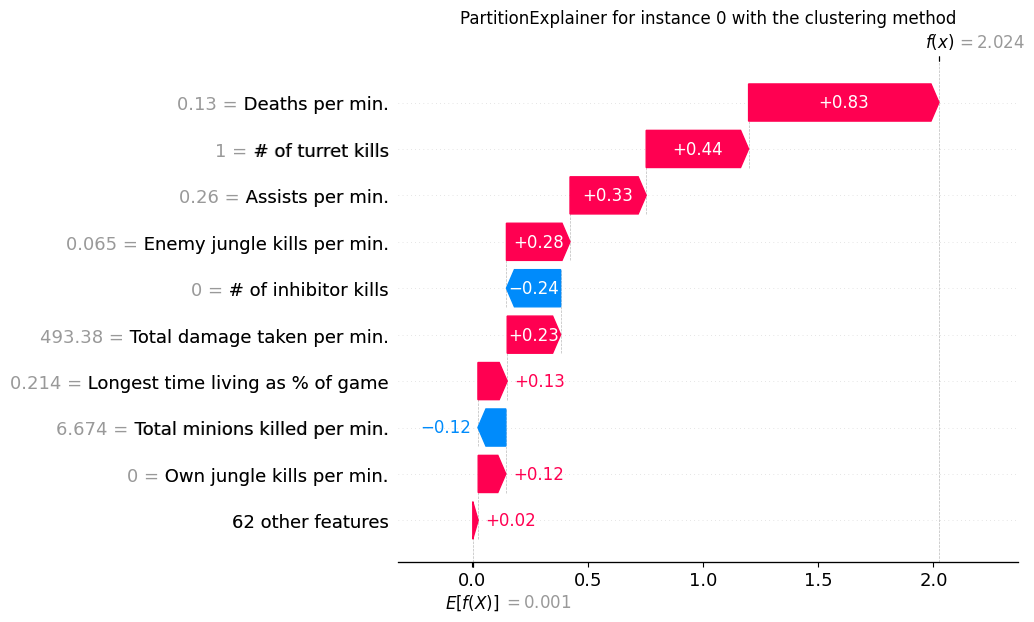

In [69]:
import matplotlib.pyplot as plt
shap_values0 = explainer(instance)
fig, ax = plt.subplots()
shap.plots.waterfall(shap_values0[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

### Explain a single player's chances of winning a particular match

SHAP values sum to the difference between the expected output of the model and the current output for the current player. Note that for the Tree SHAP implementation the margin output of the model is explained, not the transformed output (such as a probability for logistic regression). This means that the units of the SHAP values for this model are log odds ratios. Large positive values mean a player is likely to win, while large negative values mean they are likely to lose.

In [20]:
shap.force_plot(explainer.expected_value, shap_values[0, :], Xv.iloc[0, :])

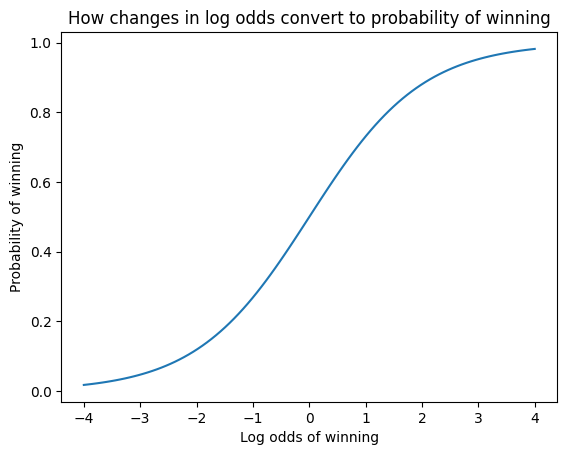

In [21]:
xs = np.linspace(-4, 4, 100)
pl.xlabel("Log odds of winning")
pl.ylabel("Probability of winning")
pl.title("How changes in log odds convert to probability of winning")
pl.plot(xs, 1 / (1 + np.exp(-xs)))
pl.show()

### Summarize the impact of all features over the entire dataset

A SHAP value for a feature of a specific prediction represents how much the model prediction changes when we observe that feature. In the summary plot below we plot all the SHAP values for a single feature (such as `goldearned`) in a row, where the x-axis is the SHAP value (which for this model is in units of log odds of winning). By doing this for all features, we see which features drive the model's prediction a lot (such as `goldearned`), and which only effect the prediction a little (such as `kills`). Note that when points don't fit together on the line they pile up vertically to show density. Each dot is also colored by the value of that feature from high to low.

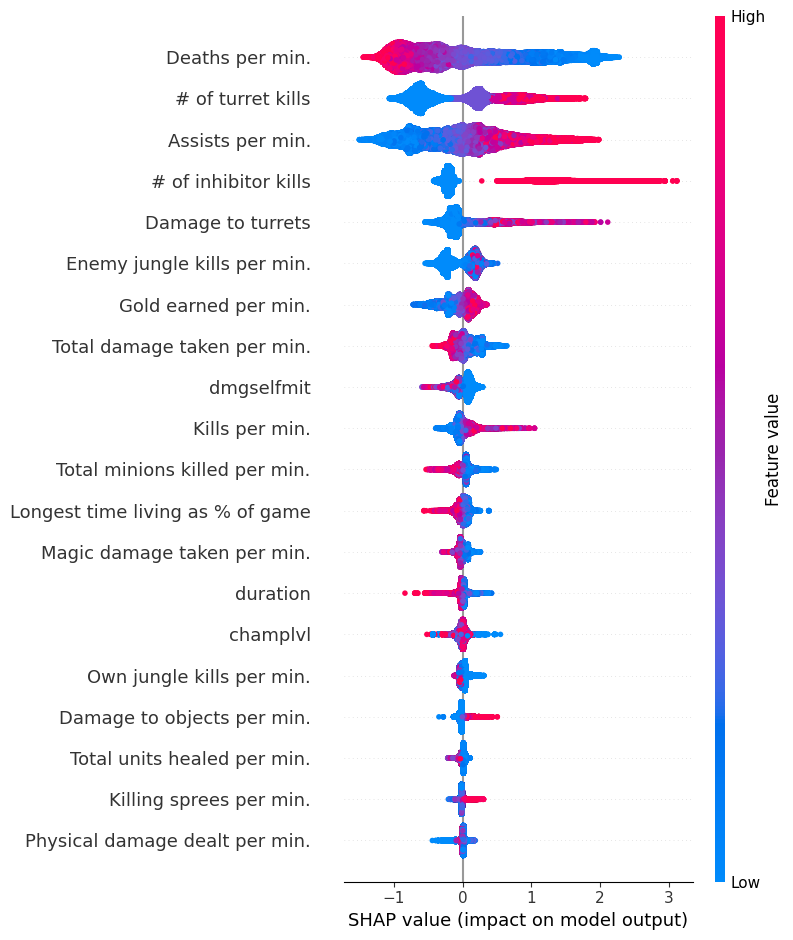

In [23]:
shap.summary_plot(shap_values, Xv)

## Examine how changes in a feature change the model's prediction

The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all players we can see how changes in the feature's value effect the model's output. Note that these plots are very similar to standard partial dependence plots, but they provide the added advantage of displaying how much context matters for a feature (or in other words how much interaction terms matter). How much interaction terms effect the importance of a feature is captured by the vertical dispersion of the data points. For example earning only 100 gold/min during a game may lower your log odds of winning by 10 for some players or only 3 for others. Why is this? Because other features of these players effect how much earning gold matters for winning the game. Note that the vertical spread narrows once you earn at least 500 gold/min, meaning the context of other features matters less for high gold earners than low gold earners. We color the datapoints with another feature that most explains the interaction effect variance. For example earning less gold is less bad if you have not died very much, but it is really bad if you also die a lot.

The y-axis in the plots below represents the SHAP value for that feature, so -4 means observing that feature lowers your log odds of winning by 4, while a value of +2 means observing that feature raises your log odds of winning by 2.

Note that these plot just explain how the XGBoost model works, not nessecarily how reality works. Since the XGBoost model is trained from observational data, it is not nessecarily a causal model, and so just because changing a factor makes the model's prediction of winning go up, does not always mean it will raise your actual chances.

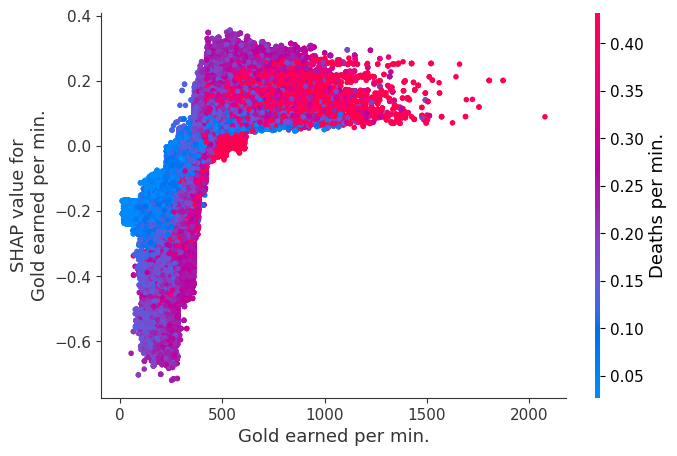

In [25]:
shap.dependence_plot("Gold earned per min.", shap_values, Xv, interaction_index="Deaths per min.")

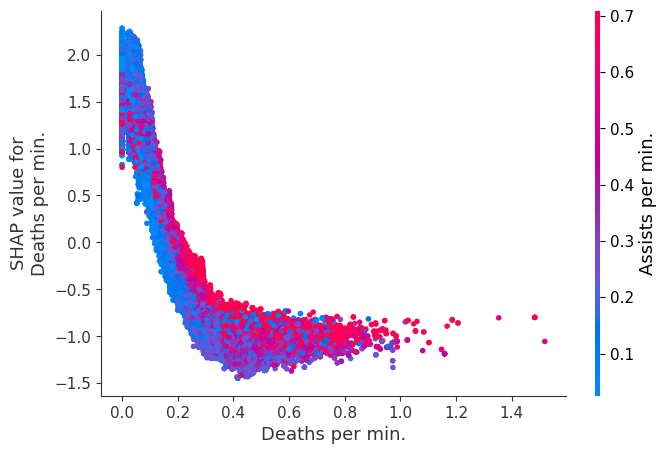

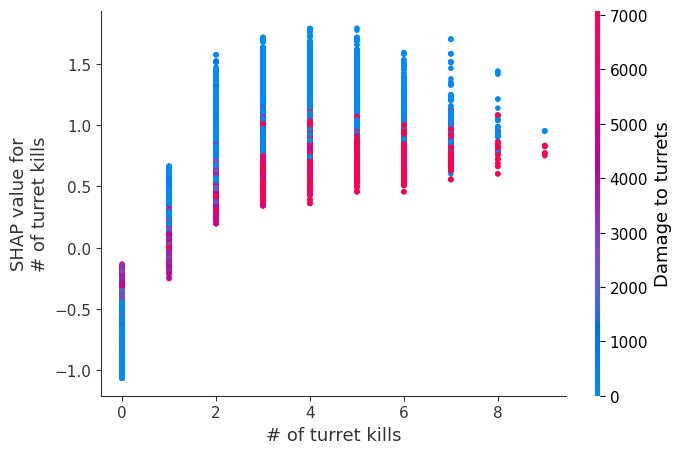

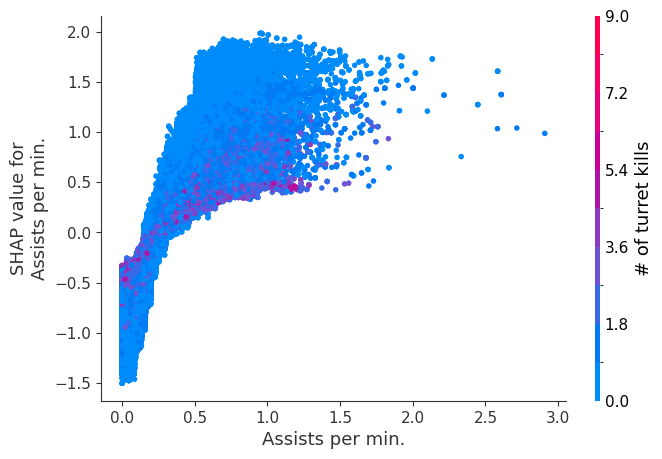

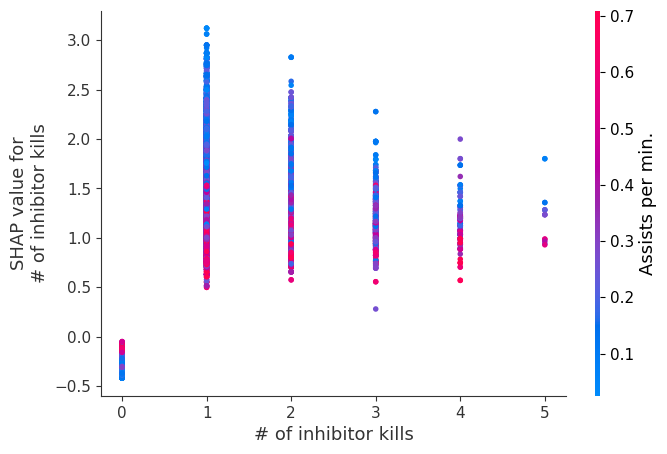

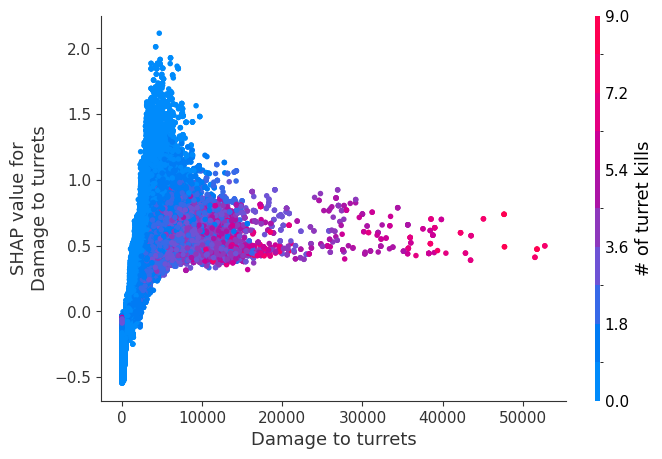

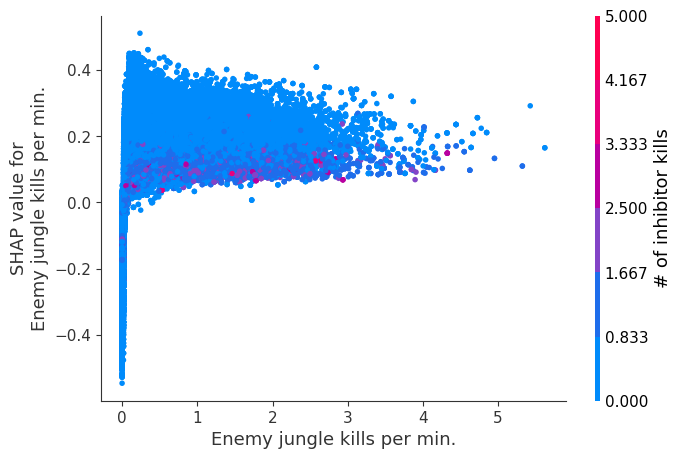

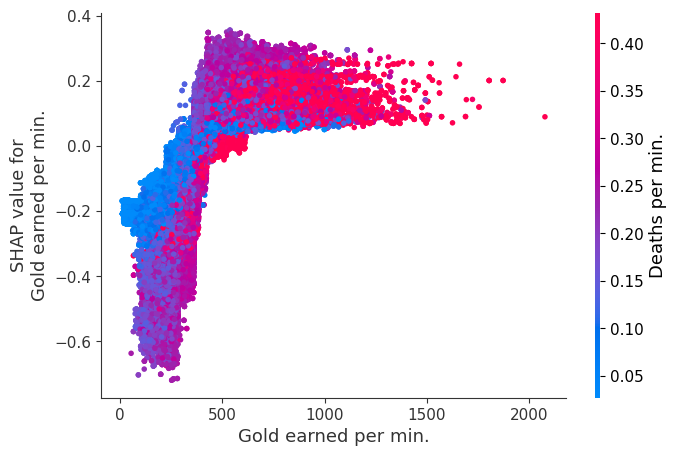

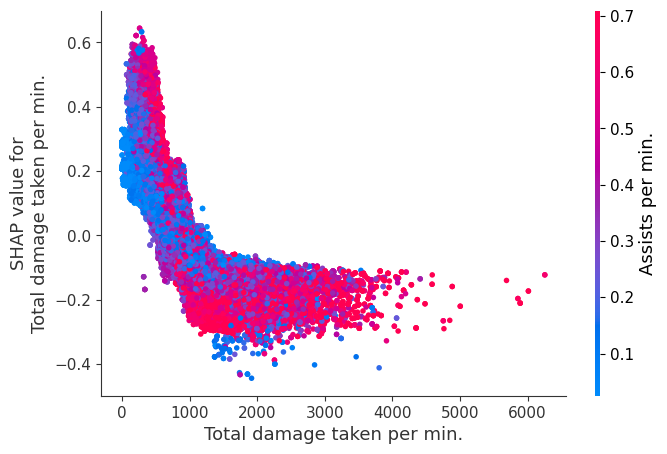

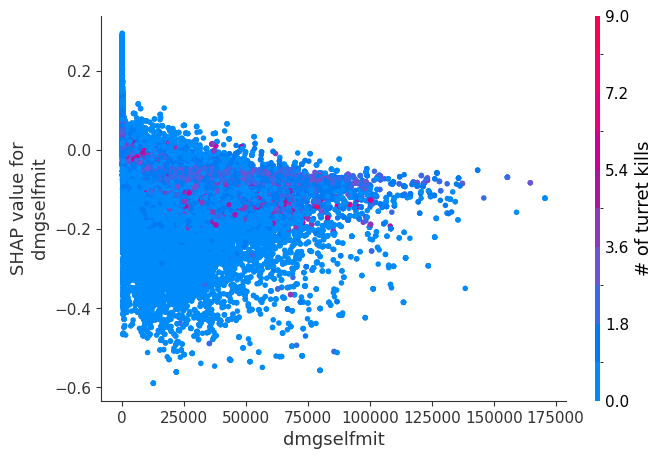

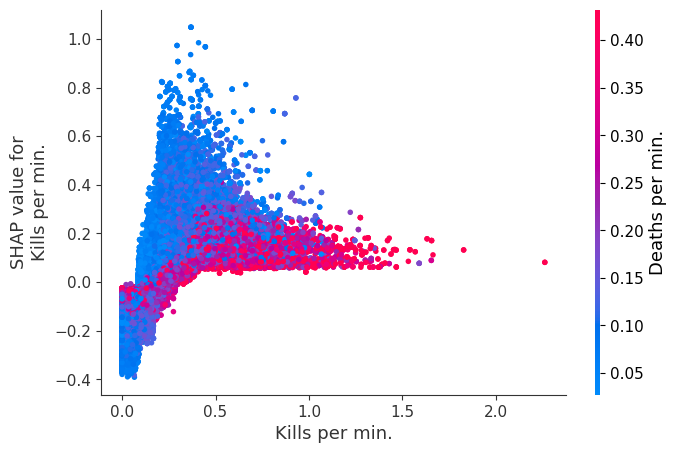

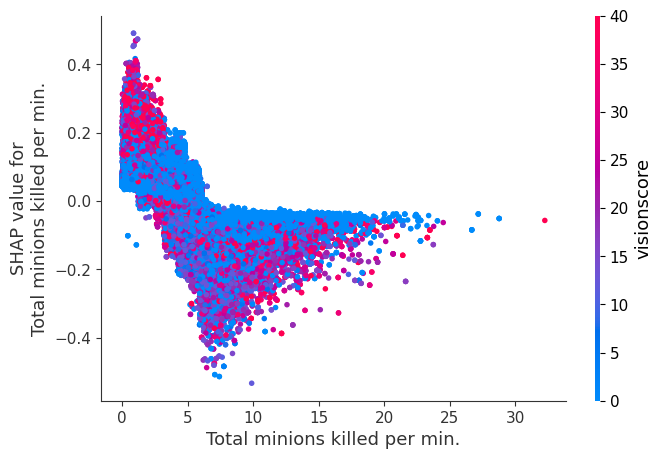

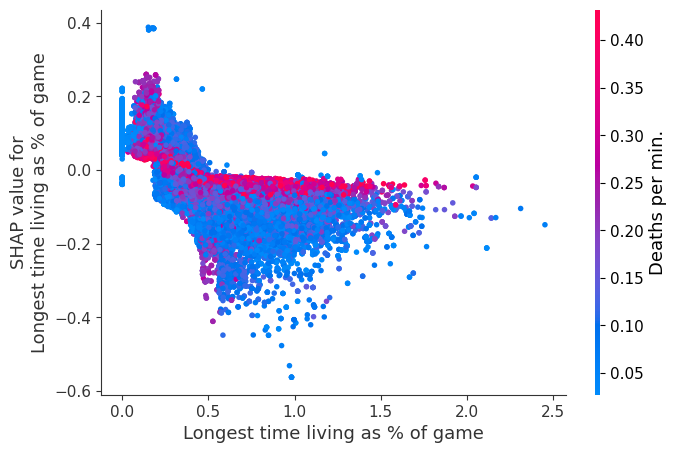

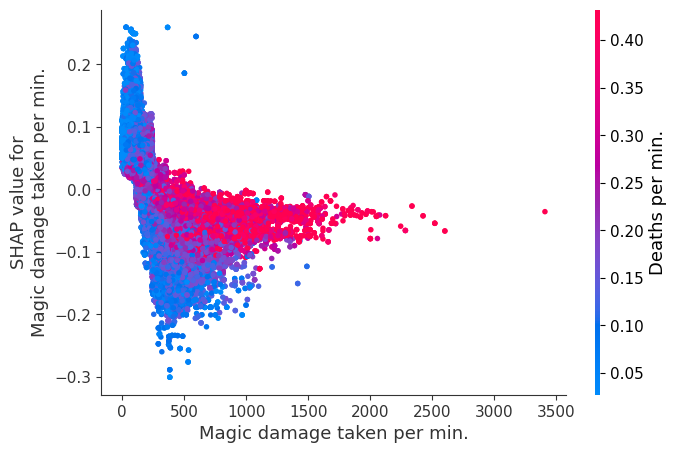

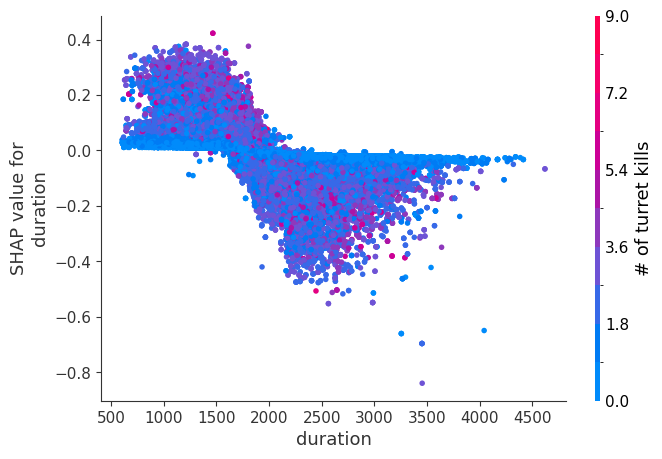

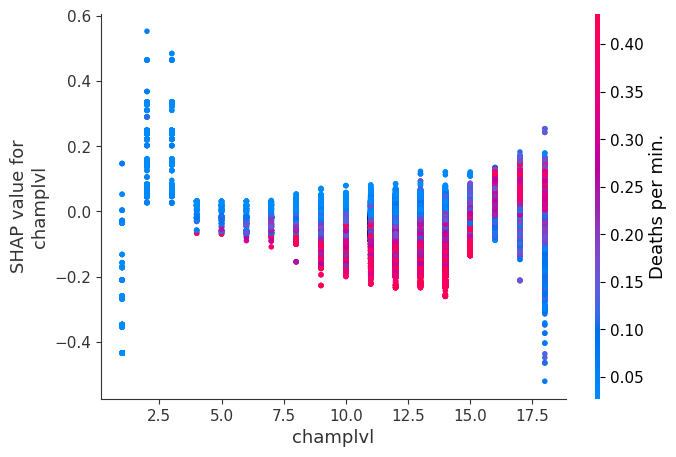

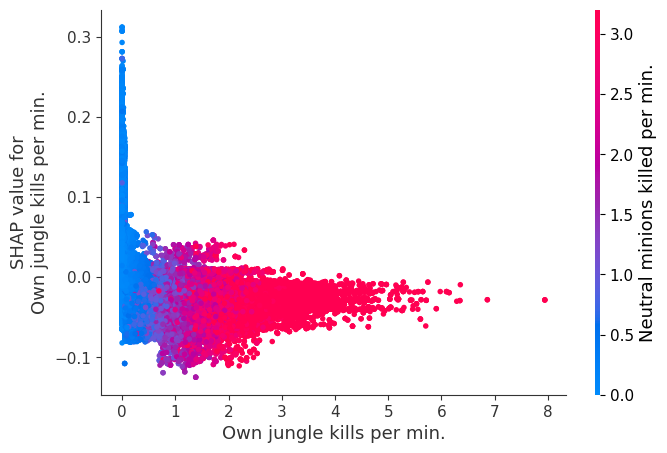

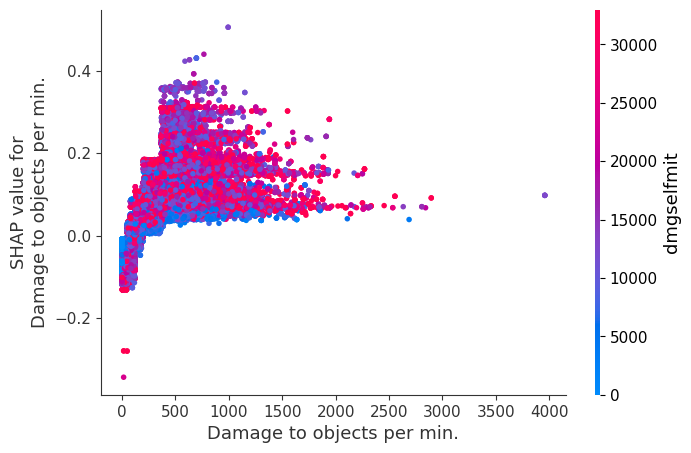

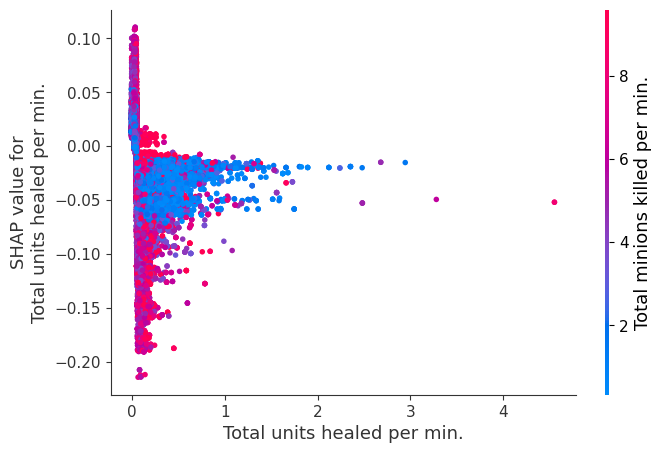

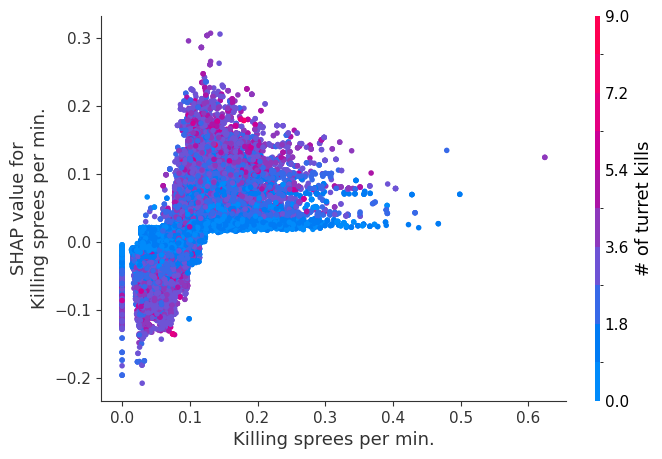

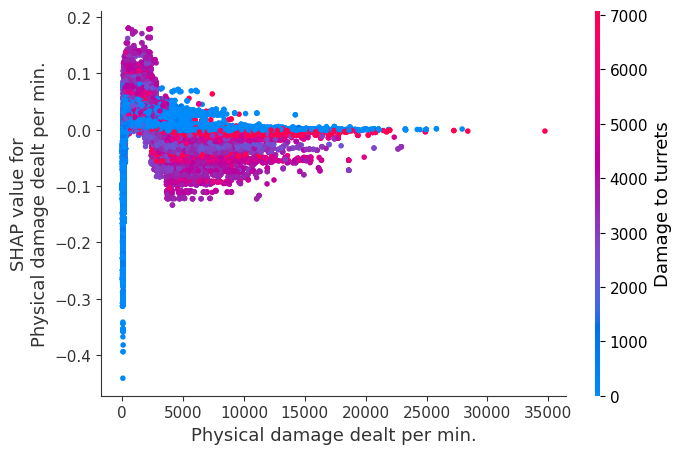

In [26]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, Xv)